# Car generator (GAN)

## Imports

In [36]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
from torchvision.utils import save_image


import numpy as np

import random

import matplotlib.pyplot as plt
import os
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading the dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop((96,128)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder('./dataset/train', transform=transform)
dataset_test = datasets.ImageFolder('./dataset/test', transform=transform)

whole_dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_test])

In [4]:
def show_car(image):
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])

In [5]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,shuffle=True)

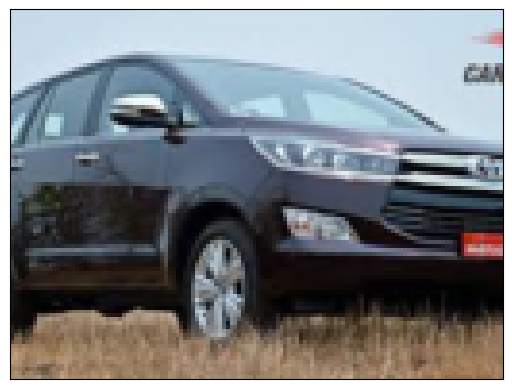

In [6]:
images, labels = next(iter(data_loader))

show_car(images[13])

In [7]:
print(labels[:2])

tensor([5, 6])


In [8]:
latent_dim = 100 + 7
img_shape = (3, 96, 128)
n_epochs = 500

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Defining the model

In [10]:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+kernel_size[0]
#Wout​=(Win​−1)×stride[1]−2×padding[1]+kernel_size[1]

#Example:
#Image is 3x4
#Kernel is 3x4
#Stride is 2x2
#Padding is 1x1
#
#H = (3-1)*2 - 2*1 + 4 = 6
#W = (4-1)*2 - 2*1 + 4 = 8

#H = (6-1)*2 - 2*1 + 4 = 12
#W = (8-1)*2 - 2*1 + 4 = 16
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.leaky = nn.LeakyReLU(0.1)

        #INPUT: (100+7) x 1 x 1
        self.trans1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size=(3,4), stride=(1,1), padding=(0,0), bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        #INPUT: 256 x 3 x 4
        self.trans2 = nn.ConvTranspose2d(256, 128, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False) 
        self.bn2 = nn.BatchNorm2d(128)

        #INPUT: 128 x 6 x 8
        self.trans3 = nn.ConvTranspose2d(128, 64, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn3 = nn.BatchNorm2d(64)

        #INPUT: 64 x 12 x 16
        self.trans4 = nn.ConvTranspose2d(64, 32, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn4 = nn.BatchNorm2d(32)
        
        #INPUT: 32 x 24 x 32
        self.trans5 = nn.ConvTranspose2d(32, 16, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn5 = nn.BatchNorm2d(16)

        #INPUT: 16 x 48 x 64
        self.trans6 = nn.ConvTranspose2d(16, 3, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.tanh = nn.Tanh() 

        #FINAL: 3 x 96 x 128

    def forward(self, z):
        z = self.trans1(z)
        z = self.bn1(z)
        z = self.leaky(z)

        z = self.trans2(z)
        z = self.bn2(z)
        z = self.leaky(z)

        z = self.trans3(z)
        z = self.bn3(z)
        z = self.leaky(z)
        
        z = self.trans4(z)
        z = self.bn4(z)
        z = self.leaky(z)

        z = self.trans5(z)
        z = self.bn5(z)
        z = self.leaky(z)

        z = self.trans6(z)
        z = self.tanh(z)
        
        return z.view(-1, *img_shape)

In [11]:
#Hout​=⌊(Hin​+2×padding[0]−kernel_size[0]​)/stride[0] + 1⌋

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.leaky = nn.LeakyReLU(0.1)

        #INPUT: 3 x 96 x 128
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        #INPUT: 32 x 48 x 64
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        #INPUT: 64 x 24 x 32
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        #INPUT: 128 x 12 x 16
        self.conv4 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(256)

        #INPUT: 256 x 6 x 8
        self.conv5 = nn.Conv2d(256,1,kernel_size=(6,8),stride=1,padding=0,bias=False)
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(256*6*8,7)

    def forward(self, z):
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.leaky(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.leaky(z)

        z = self.conv3(z)
        z = self.bn3(z)
        z = self.leaky(z)

        z = self.conv4(z)
        z = self.bn4(z)
        z = self.leaky(z)

        z_class = z.view(z.size(0),-1)
        z_class = self.fc1(z_class)
        
        z = self.conv5(z)
        z = self.sigmoid(z)
        return z, z_class

In [12]:
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (leaky): LeakyReLU(negative_slope=0.1)
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 1, kernel_size=(6, 8), stride=(1, 1), bias=False)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=12288, out_features=7, bias=True)
)

In [13]:
print(generator)
print(discriminator)

Generator(
  (leaky): LeakyReLU(negative_slope=0.1)
  (trans1): ConvTranspose2d(107, 256, kernel_size=(3, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans5): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (trans6): ConvT

In [14]:
lr = 1e-4
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

criterion = nn.BCELoss()
criterion_class = nn.CrossEntropyLoss()

In [15]:
def genRandomLabels(batch_size,n_classes):
    return torch.randint(high=n_classes, size=(batch_size,))

In [16]:
def concatenateRandomLabels(noise,labels):
    random_labels = nn.functional.one_hot(labels,7)

    return torch.cat((noise,random_labels),dim=1)

In [17]:
def addImageLabels(images,labels):
    one_hot_labels = nn.functional.one_hot(labels,7).unsqueeze(2).expand(-1,-1,96).unsqueeze(3).expand(-1,-1,-1,128)

    return torch.cat((images,one_hot_labels),dim=1)

In [18]:
def createRealLabels(batch_size, percent):
    reals = torch.ones(batch_size, 1, 1, 1).to(device)

    for i in range(batch_size):
        if random.random() < percent:
            reals[i][0][0][0] = 0
        
    return reals

def createFakeLabels(batch_size, percent):
    reals = torch.zeros(batch_size, 1, 1, 1).to(device)

    for i in range(batch_size):
        if random.random() < percent:
            reals[i][0][0][0] = 1
        
    return reals

fixed_noise = torch.Tensor(np.random.normal(0, 1, (25, latent_dim-7)))frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
random_labels = genRandomLabels(25,7)
fixed_noise = concatenateRandomLabels(fixed_noise,random_labels)
fixed_noise = torch.unsqueeze(fixed_noise,2)
fixed_noise = torch.unsqueeze(fixed_noise,3)
fixed_noise = fixed_noise.to(device)

In [19]:
for epoch in range(n_epochs):
    epoch_g_losses = []
    epoch_d_losses = []
    
    for i, (imgs, labels) in enumerate(data_loader):
        # Create fake images

        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim-7)))
        random_labels = genRandomLabels(imgs.shape[0],7)
        z = concatenateRandomLabels(z,random_labels)
        z = torch.unsqueeze(z,2)
        z = torch.unsqueeze(z,3)
        z = z.to(device)
        imgs = imgs.to(device)
        random_labels = random_labels.to(device)
        
        fake_imgs = generator(z)
        
        # Discriminator training

        optimizer_D.zero_grad()

        percent = 0.1#((n_epochs - epoch)/n_epochs)*0.2
        
        #real_with_labels = addImageLabels(imgs,labels)
        #real_with_labels = real_with_labels.to(device)

        #fake_with_labels = addImageLabels(fake_imgs,random_labels)
        #fake_with_labels = fake_with_labels.to(device)
        
        #targets_real = torch.Tensor(np.random.uniform(0.95, 1.05, (imgs.size(0), 1, 1, 1))).to(device)
        targets_real = createRealLabels(imgs.size(0), percent).to(device)
        #targets_fake = torch.Tensor(np.random.uniform(0, 0.05, (imgs.size(0), 1, 1, 1))).to(device)
        targets_fake = createFakeLabels(fake_imgs.size(0), percent).to(device)

        imgs = imgs.to(device)
        
        out_real, out_class_real = discriminator(imgs)
        out_fake, out_class_fake = discriminator(fake_imgs.detach())
        
        real_img_loss = criterion(out_real, targets_real)
        fake_img_loss = criterion(out_fake, targets_fake)

        labels = labels.to(device)
        real_img_loss_class = criterion_class(out_class_real, labels)
        fake_img_loss_class = criterion_class(out_class_fake, random_labels)

        real_img_loss = real_img_loss + real_img_loss_class
        fake_img_loss = fake_img_loss + fake_img_loss_class
        
        real_img_loss.backward()
        fake_img_loss.backward()
        
        optimizer_D.step()

        epoch_d_losses.append(real_img_loss.item())
        epoch_d_losses.append(fake_img_loss.item())

        # Generator training
        
        optimizer_G.zero_grad()

        targets = torch.ones(imgs.size(0), 1, 1, 1)
        targets = targets.to(device)

        out, out_class = discriminator(fake_imgs)

        g_loss = criterion(out, targets)
        g_loss_class = criterion_class(out_class, labels)

        g_loss = g_loss + g_loss_class
        g_loss.backward()
        optimizer_G.step()

        epoch_g_losses.append(g_loss.item())

    print(
        f"[Epoch {epoch}/{n_epochs}] [G loss: {sum(epoch_g_losses)/len(epoch_g_losses)}] [D loss: {sum(epoch_d_losses)/len(epoch_d_losses)}]"
    )

    test_images = generator(fixed_noise)

    if epoch%10 == 0:
        save_image(test_images.data[:25], f"./result/fake_{epoch}.png", nrow=5, normalize=True)

[Epoch 0/500] [G loss: 6.223433501847827] [D loss: 2.3544144543982646]
[Epoch 1/500] [G loss: 8.14703048822534] [D loss: 2.230639202449158]
[Epoch 2/500] [G loss: 8.177840134569706] [D loss: 2.205760426193703]
[Epoch 3/500] [G loss: 7.220173337077367] [D loss: 2.118619214942437]
[Epoch 4/500] [G loss: 5.739530197536673] [D loss: 2.136609414606604]
[Epoch 5/500] [G loss: 5.3610139311724945] [D loss: 2.0518566169811567]
[Epoch 6/500] [G loss: 4.942119831347283] [D loss: 2.0083688606742682]
[Epoch 7/500] [G loss: 5.620943358836283] [D loss: 2.0103723996013176]
[Epoch 8/500] [G loss: 5.665601357248903] [D loss: 1.9659997475056248]
[Epoch 9/500] [G loss: 5.3228100419954485] [D loss: 1.9372155695926143]
[Epoch 10/500] [G loss: 5.2475464981020865] [D loss: 1.939104570232275]
[Epoch 11/500] [G loss: 5.263591311360133] [D loss: 1.9175277538881956]
[Epoch 12/500] [G loss: 5.22266276374118] [D loss: 1.8864522544482283]
[Epoch 13/500] [G loss: 5.052587028678137] [D loss: 1.8669723233648838]
[Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


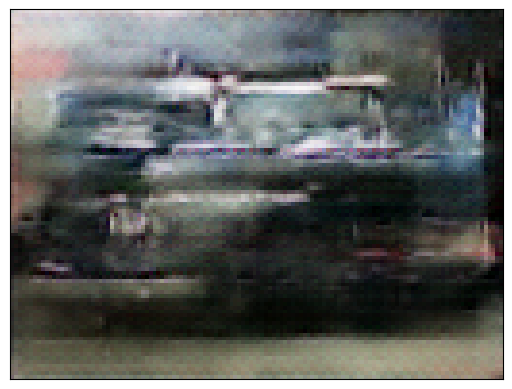

In [32]:
test_images = generator(fixed_noise)

show_car(test_images[2].cpu().detach())

In [47]:
#create video from images

video_name = 'evolution.avi'
image_folder = 'result'

list_dir = os.listdir(image_folder)
list_dir.sort()

images = [img for img in list_dir if img.endswith(".png")]

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, 2, (width,height))


for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()